# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://www.ramp.studio/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (Inria), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [1]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Load the dataset using pandas

The training and testing data are located in the folder `data`. They are compressed `csv` file (i.e. `csv.bz2`). We can load the dataset using pandas.

In [2]:
data = pd.read_csv(
    os.path.join('data', 'train.csv.bz2')
)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   log_PAX           8902 non-null   float64
 5   std_wtd           8902 non-null   float64
dtypes: float64(3), object(3)
memory usage: 417.4+ KB


So as stated earlier, the column `log_PAX` is the target for our regression problem. The other columns are the features which will be used for our prediction problem. If we focus on the data type of the column, we can see that `DateOfDeparture`, `Departure`, and `Arrival` are of `object` dtype, meaning they are strings.

In [4]:
data[['DateOfDeparture', 'Departure', 'Arrival']].head()

,DateOfDeparture,Departure,Arrival
0,2012-06-19,ORD,DFW
1,2012-09-10,LAS,DEN
2,2012-10-05,DEN,LAX
3,2011-10-09,ATL,ORD
4,2012-02-21,DEN,SFO


While it makes `Departure` and `Arrival` are the code of the airport, we see that the `DateOfDeparture` should be a date instead of string. We can use pandas to convert this data.

In [5]:
data.loc[:, 'DateOfDeparture'] = pd.to_datetime(data.loc[:, 'DateOfDeparture'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateOfDeparture   8902 non-null   datetime64[ns]
 1   Departure         8902 non-null   object        
 2   Arrival           8902 non-null   object        
 3   WeeksToDeparture  8902 non-null   float64       
 4   log_PAX           8902 non-null   float64       
 5   std_wtd           8902 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 417.4+ KB


When you will create a submission, `ramp-workflow` will load the data for you and split into a data matrix `X` and a target vector `y`. It will also take care about splitting the data into a training and testing set. These utilities are available in the module `problem.py` which we will load.

In [32]:
import problem
X, y = problem.get_train_data()

data_merger = FunctionTransformer(_merge_external_data)

v = data_merger.fit_transform(X)

In [33]:
v

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,temperature_depart,Events_depart,temperature_arrival,Events_arrival,wage_median_depart,beach_depart,passenger_per_year_depart,population_depart,latitude_deg_depart,longitude_deg_depart,score_depart,wage_median_arrival,beach_arrival,passenger_per_year_arrival,population_arrival,latitude_deg_arrival,longitude_deg_arrival,score_arrival,Open,prix,is_holiday
0,2012-06-19,ORD,DFW,12.875000,9.812647,35.0,NaN,34.0,NaN,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,53078.666667,0,66233.791000,1242115,32.896801,-97.038002,1203175,12.50,3.729,0
1,2012-06-19,ORD,PHX,11.772727,8.970490,35.0,NaN,42.0,NaN,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,57474.666667,0,45664.733333,1499274,33.434299,-112.012001,1060875,12.50,3.729,0
2,2012-06-19,ORD,SFO,13.480000,9.372477,35.0,NaN,23.0,NaN,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,82083.000000,1,49668.409667,828876,37.618999,-122.375000,1112475,12.50,3.729,0
3,2012-06-19,ORD,ATL,11.173913,8.819669,35.0,NaN,31.0,NaN,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,61467.666667,0,105911.923000,449016,33.636700,-84.428101,2002475,12.50,3.729,0
4,2012-09-10,LAS,DEN,14.285714,9.466734,36.0,NaN,33.0,NaN,55440.666667,0,46505.605000,593275,36.080101,-115.152000,1068475,55482.666667,0,59852.550000,635163,39.861698,-104.672997,1103275,12.10,4.132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,2011-10-02,DTW,ATL,9.263158,7.316967,17.0,Rain,20.0,NaN,44130.000000,0,36522.355000,700183,42.212399,-83.353401,1079375,61467.666667,0,105911.923000,449016,33.636700,-84.428101,2002475,5.96,3.786,0
8898,2012-09-25,DFW,ORD,12.772727,10.641034,35.0,NaN,25.0,NaN,53078.666667,0,66233.791000,1242115,32.896801,-97.038002,1203175,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,10.56,4.086,0
8899,2012-01-19,SFO,LAS,11.047619,7.908705,11.0,Rain,13.0,NaN,82083.000000,1,49668.409667,828876,37.618999,-122.375000,1112475,55440.666667,0,46505.605000,593275,36.080101,-115.152000,1068475,6.06,3.854,0
8900,2013-02-03,ORD,PHL,6.076923,4.030334,-6.0,Snow,1.0,Snow,58419.666667,1,75120.345000,2719141,41.978600,-87.904800,1503175,39645.333333,0,34276.636000,1551824,39.871899,-75.241096,1031075,14.43,3.927,0


In [24]:
data_encoder = FunctionTransformer(_encode_data)
v2 = data_encoder.fit_transform(v)
v2

Index(['Departure', 'Arrival', 'WeeksToDeparture', 'std_wtd',
       'temperature_depart', 'temperature_arrival', 'wage_median_depart',
       'beach_depart', 'passenger_per_year_depart', 'population_depart',
       'score_depart', 'wage_median_arrival', 'beach_arrival',
       'passenger_per_year_arrival', 'population_arrival', 'score_arrival',
       'Open', 'prix', 'is_holiday', 'year', 'month', 'day', 'weekday', 'week',
       'n_days', 'weekend', 'ete', 'beach_ete_dep', 'beach_ete_arr',
       'precipitations_depart', 'precipitations_arrival', 'distance'],
      dtype='object')


,Departure,Arrival,WeeksToDeparture,std_wtd,temperature_depart,temperature_arrival,wage_median_depart,beach_depart,passenger_per_year_depart,population_depart,score_depart,wage_median_arrival,beach_arrival,passenger_per_year_arrival,population_arrival,score_arrival,Open,prix,is_holiday,year,month,day,weekday,week,n_days,weekend,ete,beach_ete_dep,beach_ete_arr,precipitations_depart,precipitations_arrival,distance
0,ORD,DFW,12.875000,9.812647,35.0,34.0,58419.666667,1,75120.345000,2719141,1503175,53078.666667,0,66233.791000,1242115,1203175,12.50,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,1289.834980
1,ORD,PHX,11.772727,8.970490,35.0,42.0,58419.666667,1,75120.345000,2719141,1503175,57474.666667,0,45664.733333,1499274,1060875,12.50,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,2311.973417
2,ORD,SFO,13.480000,9.372477,35.0,23.0,58419.666667,1,75120.345000,2719141,1503175,82083.000000,1,49668.409667,828876,1112475,12.50,3.729,0,2012,6,19,1,25,15510,1,1,1,1,0,0,2962.102280
3,ORD,ATL,11.173913,8.819669,35.0,31.0,58419.666667,1,75120.345000,2719141,1503175,61467.666667,0,105911.923000,449016,2002475,12.50,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,975.714847
4,LAS,DEN,14.285714,9.466734,36.0,33.0,55440.666667,0,46505.605000,593275,1068475,55482.666667,0,59852.550000,635163,1103275,12.10,4.132,0,2012,9,10,0,37,15593,1,0,0,0,0,0,1008.730894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,DTW,ATL,9.263158,7.316967,17.0,20.0,44130.000000,0,36522.355000,700183,1079375,61467.666667,0,105911.923000,449016,2002475,5.96,3.786,0,2011,10,2,6,39,15249,0,1,0,0,1,0,957.595992
8898,DFW,ORD,12.772727,10.641034,35.0,25.0,53078.666667,0,66233.791000,1242115,1203175,58419.666667,1,75120.345000,2719141,1503175,10.56,4.086,0,2012,9,25,1,39,15608,1,0,0,0,0,0,1289.834980
8899,SFO,LAS,11.047619,7.908705,11.0,13.0,82083.000000,1,49668.409667,828876,1112475,55440.666667,0,46505.605000,593275,1068475,6.06,3.854,0,2012,1,19,3,3,15358,0,0,0,0,1,0,664.474071
8900,ORD,PHL,6.076923,4.030334,-6.0,1.0,58419.666667,1,75120.345000,2719141,1503175,39645.333333,0,34276.636000,1551824,1031075,14.43,3.927,0,2013,2,3,6,5,15739,0,0,0,0,1,1,1087.640371


In [25]:
categorical_encoder = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)

categorical_cols = ['Arrival', 'Departure']

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

In [28]:
v3=pd.DataFrame(preprocessor.fit_transform(v2),columns = v2.columns)

In [29]:
v3

,Departure,Arrival,WeeksToDeparture,std_wtd,temperature_depart,temperature_arrival,wage_median_depart,beach_depart,passenger_per_year_depart,population_depart,score_depart,wage_median_arrival,beach_arrival,passenger_per_year_arrival,population_arrival,score_arrival,Open,prix,is_holiday,year,month,day,weekday,week,n_days,weekend,ete,beach_ete_dep,beach_ete_arr,precipitations_depart,precipitations_arrival,distance
0,4.0,15.0,12.875,9.812647,35.0,34.0,58419.666667,1,75120.345,2719141,1503175,53078.666667,0,66233.791,1242115,1203175,12.5,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,1289.83498
1,17.0,15.0,11.772727,8.97049,35.0,42.0,58419.666667,1,75120.345,2719141,1503175,57474.666667,0,45664.733333,1499274,1060875,12.5,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,2311.973417
2,19.0,15.0,13.48,9.372477,35.0,23.0,58419.666667,1,75120.345,2719141,1503175,82083.0,1,49668.409667,828876,1112475,12.5,3.729,0,2012,6,19,1,25,15510,1,1,1,1,0,0,2962.10228
3,0.0,15.0,11.173913,8.819669,35.0,31.0,58419.666667,1,75120.345,2719141,1503175,61467.666667,0,105911.923,449016,2002475,12.5,3.729,0,2012,6,19,1,25,15510,1,1,1,0,0,0,975.714847
4,3.0,9.0,14.285714,9.466734,36.0,33.0,55440.666667,0,46505.605,593275,1068475,55482.666667,0,59852.55,635163,1103275,12.1,4.132,0,2012,9,10,0,37,15593,1,0,0,0,0,0,1008.730894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8897,0.0,5.0,9.263158,7.316967,17.0,20.0,44130.0,0,36522.355,700183,1079375,61467.666667,0,105911.923,449016,2002475,5.96,3.786,0,2011,10,2,6,39,15249,0,1,0,0,1,0,957.595992
8898,15.0,4.0,12.772727,10.641034,35.0,25.0,53078.666667,0,66233.791,1242115,1203175,58419.666667,1,75120.345,2719141,1503175,10.56,4.086,0,2012,9,25,1,39,15608,1,0,0,0,0,0,1289.83498
8899,9.0,19.0,11.047619,7.908705,11.0,13.0,82083.0,1,49668.409667,828876,1112475,55440.666667,0,46505.605,593275,1068475,6.06,3.854,0,2012,1,19,3,3,15358,0,0,0,0,1,0,664.474071
8900,16.0,15.0,6.076923,4.030334,-6.0,1.0,58419.666667,1,75120.345,2719141,1503175,39645.333333,0,34276.636,1551824,1031075,14.43,3.927,0,2013,2,3,6,5,15739,0,0,0,0,1,1,1087.640371


In [30]:
regressor = RandomForestRegressor(
    n_estimators=500, max_depth=10, max_features="auto", n_jobs=-1
)

regressor.fit(v3,y)

RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1)

In [31]:
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(v3)

np.sqrt(mean_squared_error(y,y_pred))



0.884016665878344

In [17]:
 # Data augmentation transformer (add a column)
data_merger = FunctionTransformer(_merge_external_data)
data_encoder = FunctionTransformer(_encode_data)

    # preprocessor for categorical variables
categorical_encoder = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)
categorical_cols = ['Arrival', 'Departure']

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

    # Regressor to do the prediction
regressor = RandomForestRegressor(
    n_estimators=500, max_depth=10, max_features="auto", n_jobs=-1
)

    # Create a pipeline to return a scikit-learn estimator that will
    # be used in ramp-test to do across validation
    

    
make_pipeline(
    data_merger, data_encoder,
    preprocessor, regressor
)



Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x00000126E89E54C8>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_data at 0x00000126E89E5B88>)),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['Arrival', 'Departure'])])),
                ('rand

The function `get_train_data()` loads the training data and returns a pandas dataframe `X` and a numpy vector `y`.

In [76]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor



def _merge_external_data(X):


    ########################### Date data ##################################

  #  filepath_one = os.path.join(
   #     os.path.dirname(__file__), 'external_data.csv'
   # )

    ####### Make sure that DateOfDeparture is of dtype datetime #######

    X = X.copy()  # modify a copy of X
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    # Parse date to also be of dtype datetime
    data=pd.read_csv(r'C:\Users\yanis\01 Projets\01 Python Projects\Projet_Air_Passenger\air_passengers\submissions\Test_1\external_data.csv',index_col=0,parse_dates=["Date"])
    
    ####### Take data for the departure airport #######

    X_weather = data[['Date', 'AirPort', 'Max TemperatureC','Events']]

    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Departure', 'Max TemperatureC':'temperature_depart','Events':'Events_depart'}
    )

    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Departure'], sort=False
    )

    ####### Take data for the arrival airport #######

    X_weather = data[['Date', 'AirPort', 'Max TemperatureC','Events']]

    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival', 'Max TemperatureC':'temperature_arrival', 'Events':'Events_arrival'}
    )

    X_merged_meteo = pd.merge(
        X_merged, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )


    ########################### airport data ##################################


    ####### Take data for the departure airport #######

    X = X_merged_meteo.copy() 

    X_airport = data[['Date','AirPort', 'wage median','beach','passenger per year','population','latitude_deg','longitude_deg','score']]
    X_airport = X_airport.rename(
        columns={'Date': 'DateOfDeparture','AirPort':'Departure', 'wage median':'wage_median_depart', 'beach':'beach_depart', 'passenger per year':'passenger_per_year_depart',
            'population':'population_depart', 'latitude_deg':'latitude_deg_depart', 'longitude_deg':'longitude_deg_depart','score':'score_depart'}
    )

    X_merged_airport = pd.merge(
        X, X_airport, how='inner', on=['DateOfDeparture','Departure'], sort=False
    )


    ####### Take data for the arrival airport #######

    X = X_merged_airport.copy()


    X_airport = data[['Date','AirPort', 'wage median','beach','passenger per year','population','latitude_deg','longitude_deg','score']]
    X_airport = X_airport.rename(
        columns={'Date':'DateOfDeparture','AirPort':'Arrival', 'wage median':'wage_median_arrival', 'beach':'beach_arrival', 'passenger per year':'passenger_per_year_arrival',
            'population':'population_arrival','latitude_deg':'latitude_deg_arrival','longitude_deg':'longitude_deg_arrival','score':'score_arrival'}
    )

    X_merged_airport = pd.merge(
        X, X_airport, how='left', on=['DateOfDeparture','Arrival'], sort=False
    )


    ######################## stocks fuel holiday data ###################################

    X = X_merged_airport.copy()

    data_stocks_fuel_holiday = data[['Date', 'AirPort', 'Open','prix','is_holiday']]
    data_stocks_fuel_holiday = data_stocks_fuel_holiday.rename(
        columns={'Date': 'DateOfDeparture','AirPort':'Arrival'})
    X_merged = pd.merge(
        X, data_stocks_fuel_holiday, how='left', on=['DateOfDeparture','Arrival'], sort=False)
	
    return X_merged



In [77]:
def _encode_data(X):

    ################# encoding the date #########################

    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['DateOfDeparture'].dt.year
    X.loc[:, 'month'] = X['DateOfDeparture'].dt.month
    X.loc[:, 'day'] = X['DateOfDeparture'].dt.day
    X.loc[:, 'weekday'] = X['DateOfDeparture'].dt.weekday
    X.loc[:, 'week'] = X['DateOfDeparture'].dt.isocalendar().week
    X.loc[:, 'n_days'] = X['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    
    X['weekend'] = np.where(X['weekday'].isin([0,1]),1,0)
    X['ete'] = np.where(X['month'].isin([10,5,6]),1,0)
    
    X['beach_ete_dep'] = X['ete'] * X['beach_depart']
    X['beach_ete_arr'] = X['ete'] * X['beach_arrival']
    
    ################# encoding the meteo #########################

    # From the meteo data we supply more information
    X["precipitations_depart"]=X.apply(lambda x: 0 if pd.isnull(x['Events_depart']) else 1, axis=1)
    X["precipitations_arrival"]=X.apply(lambda x: 0 if pd.isnull(x['Events_arrival']) else 1, axis=1)
    #X["diff_temp"]=X['temperature_depart']-X['temperature_arrival']

    ################# encoding the distance #########################

    # calculer la distance entre les deux aeroports


# approximate radius of earth in km

    def haversine_vectorize(lon1, lat1, lon2, lat2):

        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        newlon = lon2 - lon1
        newlat = lat2 - lat1

        haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

        dist = 2 * np.arcsin(np.sqrt(haver_formula ))
        km = 6367 * dist #6367 for distance in KM for miles use 3958
        return km
    
    X["distance"]=haversine_vectorize(X['longitude_deg_depart'],X['latitude_deg_depart'],X['longitude_deg_arrival'],
                        X['latitude_deg_arrival'])

 

    ################# ending the encoding #########################

    # Finally we can drop the original columns from the dataframe
    X.drop(columns=["DateOfDeparture"],inplace=True)
    X.drop(columns=["Events_depart"],inplace=True)
    X.drop(columns=["Events_arrival"],inplace=True)
    X.drop(columns=["latitude_deg_depart"],inplace=True)
    X.drop(columns=["latitude_deg_arrival"],inplace=True)
    X.drop(columns=["longitude_deg_depart"],inplace=True)
    X.drop(columns=["longitude_deg_arrival"],inplace=True)
    
    print(X.columns)
    return X

In [9]:
type(X)

pandas.core.frame.DataFrame

In [10]:
type(y)

numpy.ndarray

We can check the information of the data `X`

In [42]:
import os
import math
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [43]:

def label_encoding(X): 
    mapper_ = {'day': {'31': 0,
      '2': 1,
      '3': 2,
      '4': 3,
      '1': 4,
      '29': 5,
      '5': 6,
      '8': 7,
      '24': 8,
      '25': 9,
      '26': 10,
      '28': 11,
      '23': 12,
      '22': 13,
      '19': 14,
      '30': 15,
      '21': 16,
      '27': 17,
      '7': 18,
      '15': 19,
      '18': 20,
      '12': 21,
      '17': 22,
      '9': 23,
      '14': 24,
      '10': 25,
      '11': 26,
      '6': 27,
      '16': 28,
      '20': 29,
      '13': 30},
     'weekday': {'5': 0, '6': 1, '1': 2, '4': 3, '2': 4, '0': 5, '3': 6},
     'week': {'52': 0,
      '47': 1,
      '27': 2,
      '1': 3,
      '51': 4,
      '10': 5,
      '14': 6,
      '35': 7,
      '4': 8,
      '5': 9,
      '7': 10,
      '44': 11,
      '3': 12,
      '9': 13,
      '8': 14,
      '2': 15,
      '6': 16,
      '33': 17,
      '31': 18,
      '48': 19,
      '50': 20,
      '32': 21,
      '36': 22,
      '13': 23,
      '34': 24,
      '28': 25,
      '11': 26,
      '45': 27,
      '49': 28,
      '15': 29,
      '21': 30,
      '30': 31,
      '12': 32,
      '19': 33,
      '39': 34,
      '24': 35,
      '26': 36,
      '46': 37,
      '17': 38,
      '40': 39,
      '22': 40,
      '29': 41,
      '16': 42,
      '25': 43,
      '43': 44,
      '37': 45,
      '41': 46,
      '18': 47,
      '23': 48,
      '42': 49,
      '38': 50,
      '20': 51},
     'month': {'12': 0,
      '1': 1,
      '2': 2,
      '3': 3,
      '11': 4,
      '7': 5,
      '8': 6,
      '4': 7,
      '9': 8,
      '10': 9,
      '6': 10,
      '5': 11},
     'year': {'2013': 0, '2012': 1, '2011': 2}}
    def label_encoder(X,col,mapper_):
        mapper = mapper_[col]
        X.loc[:,col] = X.loc[:,col].astype('str')
        for k in mapper.keys():
            X[col] = np.where(X[col]==k , mapper[k] , X[col] )
        X.loc[:,col] = X.loc[:,col].astype('float')
        return X

    for col in ['day','weekday','week','month','year'] :
        X = label_encoder(X,col,mapper_)
    return X



In [44]:


def _merge_external_data(X):
    #filepath = os.path.join(
      #  os.path.dirname(__file__), 'external_data.csv'
  # ) 
    X = X.copy()  # to avoid raising SettingOnCopyWarning
    # Make sure that DateOfDeparture is of dtype datetime
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    X.loc[:,'mois'] = X.loc[:, "DateOfDeparture"].dt.month
    X.loc[:,'annee'] = X.loc[:, "DateOfDeparture"].dt.year
    
    
    # Parse date to also be of dtype datetime
    external = pd.read_csv(r'C:\Users\yanis\01 Projets\01 Python Projects\Projet_Air_Passenger\air_passengers\submissions\Test_4\external_data.csv',sep=';')
    external.loc[:, "Date"] = pd.to_datetime(external['Date'])
    X_weather = external[['Date', 'AirPort', 'Max TemperatureC','Min TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    X_merged =  X_merged.rename(columns={'DateOfDeparture': 'Date'})


    static = external.drop(columns=['AirPort','Date','Max TemperatureC','Min TemperatureC','is_holiday','Dernier','passenger per year','plage','wage median','pax','annee','mois'])
    static = static.drop_duplicates()


    col_name_mapper = dict(zip(static.columns , [x + '_dep' for x in static.columns]))
    merged_dep = static.rename(columns=col_name_mapper)
    merged2 = pd.merge(
            X_merged, merged_dep, how='left', left_on='Departure',right_on = 'local_code_dep', sort=False
        )
    
    col_name_mapper = dict(zip(static.columns , [x + '_arr' for x in static.columns]))
    merged_arr = static.rename(columns=col_name_mapper)
    merged3 = pd.merge(
            merged2, merged_arr, how='left', left_on='Arrival',right_on = 'local_code_arr', sort=False
        )

    merged3.loc[:,['latitude_deg_arr','latitude_deg_dep','longitude_deg_arr',
               'longitude_deg_dep','score_dep','score_arr','scheduled_service_arr','scheduled_service_dep']] = merged3.loc[:,['latitude_deg_arr','latitude_deg_dep','longitude_deg_arr',
               'longitude_deg_dep','score_dep','score_arr','scheduled_service_arr','scheduled_service_dep']].astype('float')
    def haversine(coord1, coord2):

        R = 6372800  # Earth radius in meters
        lat1, lon1 = coord1
        lat2, lon2 = coord2

        phi1, phi2 = math.radians(lat1), math.radians(lat2) 
        dphi       = math.radians(lat2 - lat1)
        dlambda    = math.radians(lon2 - lon1)

        a = math.sin(dphi/2)**2 + \
            math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2

        return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

    merged3['coord_dep'] = merged3.apply(lambda x : (x.latitude_deg_dep,x.longitude_deg_dep) , axis=1)
    merged3['coord_arr'] = merged3.apply(lambda x : (x.latitude_deg_arr,x.longitude_deg_arr) , axis=1)
    merged3['coord_dep'] = merged3['coord_dep'].apply(lambda x : tuple(x))
    merged3['coord_arr'] = merged3['coord_arr'].apply(lambda x : tuple(x))
    merged3['distance'] = merged3.apply(lambda x : haversine(x.coord_dep, x.coord_arr),axis=1)

    to_del = ['coord','local_code','longitude_deg','latitude_deg','city']                                                                                                                          

    merged4 = pd.merge(
            merged3, external[['Date','Dernier','is_holiday']].drop_duplicates() , how='left', on = 'Date', sort=False
        )

    merged4['Dernier'].fillna(method='bfill',inplace=True)
    merged4['Dernier'].fillna(method='ffill',inplace=True)
    
    select = ['AirPort','annee','mois','pax']
    
    merged = pd.merge(merged4, external[select].rename(columns={'AirPort':'Departure'}) , how='left' , on =['Departure','mois','annee'] ,sort=False)
    merged.rename(columns={'pax':'pax_dep'},inplace=True)
    merged.drop_duplicates(inplace=True)
    
    merged_last = pd.merge(merged, external[select].rename(columns={'AirPort':'Arrival'}) , how='left' , on =['Arrival','mois','annee'] ,sort=False)
    merged_last.drop_duplicates(inplace=True)
    merged_last.rename(columns={'pax':'pax_arr'},inplace=True)
    
    
    merged_last2 = pd.merge(merged_last, external[['AirPort','wage median','plage','passenger per year']].rename(columns={'AirPort':'Departure'}) , how='left' , on =['Departure'] ,sort=False)
    merged_last2.rename(columns={'wage median':'wage median_dep','plage':'plage_dep','passenger per year': 'passenger per year_dep'},inplace=True)
    merged_last2.drop_duplicates(inplace=True)
    
    merged_last22 = pd.merge(merged_last2, external[['AirPort','wage median','plage','passenger per year']].rename(columns={'AirPort':'Arrival'}) , how='left' , on =['Arrival'] ,sort=False)
    merged_last22.rename(columns={'wage median':'wage median_arr','plage':'plage_arr','passenger per year': 'passenger per year_arr'},inplace=True)
    merged_last22.drop_duplicates(inplace=True)
    
    return merged_last22.drop(columns=[x + '_arr' for x in to_del]+[x + '_dep' for x in to_del] + ['annee','mois'])


In [45]:

def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191

    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'Date'] = pd.to_datetime(X_encoded['Date'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['Date'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['Date'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['Date'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['Date'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['Date'].dt.week
    X_encoded.loc[:, 'n_days'] = X_encoded['Date'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["Date"])

In [47]:
import problem
X, y = problem.get_train_data()

date_encoder = FunctionTransformer(_encode_dates,validate=False)
date_cols = ["Date"]
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["Arrival", "Departure"]

data_merger = FunctionTransformer(_merge_external_data)

v = data_merger.fit_transform(X)
v

# Data augmentation transformer (add a column)
data_merger = FunctionTransformer(_merge_external_data)
data_encoder = FunctionTransformer(_encode_data)

# preprocessor for categorical variables
categorical_encoder = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder()
)
categorical_cols = ['Arrival', 'Departure']

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

# Regressor to do the prediction
regressor = RandomForestRegressor(
    n_estimators=500, max_depth=10, max_features="auto", n_jobs=-1
)

# Create a pipeline to return a scikit-learn estimator that will
# be used in ramp-test to do across validation
    
pipeline=make_pipeline(data_merger, data_encoder,preprocessor, regressor)

,Date,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC,Min TemperatureC,population_dep,scheduled_service_dep,score_dep,population_arr,scheduled_service_arr,score_arr,distance,Dernier,is_holiday,pax_dep,pax_arr,wage median_dep,plage_dep,passenger per year_dep,wage median_arr,plage_arr,passenger per year_arr
0,2012-06-19,ORD,DFW,12.875000,9.812647,34,24,2719141,1.0,1503175.0,1242115,1.0,1203175.0,1.291010e+06,2.719,0,6361165.0,5298743.0,58419.666667,1,75120.345000,53078.666667,0,66233.791000
552,2012-09-10,LAS,DEN,14.285714,9.466734,33,16,593275,1.0,1068475.0,635163,1.0,1103275.0,1.009650e+06,3.247,0,3430249.0,4379049.0,55440.666667,0,46505.605000,55482.666667,0,59852.550000
1104,2012-10-05,DEN,LAX,10.863636,9.035883,22,16,635163,1.0,1103275.0,3851202,1.0,1335475.0,1.385531e+06,3.158,0,4505553.0,5191438.0,55482.666667,0,59852.550000,59541.333333,1,73928.405667
1656,2011-10-09,ATL,ORD,11.480000,7.990202,27,11,449016,1.0,2002475.0,2719141,1.0,1503175.0,9.766037e+05,3.237,0,8047271.0,5939129.0,61467.666667,0,105911.923000,58419.666667,1,75120.345000
2208,2012-02-21,DEN,SFO,11.450000,9.517159,16,8,635163,1.0,1103275.0,828876,1.0,1112475.0,1.553214e+06,3.237,0,3759019.0,3218600.0,55482.666667,0,59852.550000,82083.000000,1,49668.409667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4911144,2011-10-02,DTW,ATL,9.263158,7.316967,20,8,700183,1.0,1079375.0,449016,1.0,2002475.0,9.584683e+05,3.135,0,2808979.0,8047271.0,44130.000000,0,36522.355000,61467.666667,0,105911.923000
4911696,2012-09-25,DFW,ORD,12.772727,10.641034,25,9,1242115,1.0,1203175.0,2719141,1.0,1503175.0,1.291010e+06,3.135,0,4592608.0,5804905.0,53078.666667,0,66233.791000,58419.666667,1,75120.345000
4912248,2012-01-19,SFO,LAS,11.047619,7.908705,13,3,828876,1.0,1112475.0,593275,1.0,1068475.0,6.650794e+05,3.093,0,3218600.0,3175897.0,82083.000000,1,49668.409667,55440.666667,0,46505.605000
4912800,2013-02-03,ORD,PHL,6.076923,4.030334,1,-3,2719141,1.0,1503175.0,1551824,1.0,1031075.0,1.088631e+06,3.093,0,4399312.0,2161555.0,58419.666667,1,75120.345000,39645.333333,0,34276.636000


In [48]:
vars_to_encode = ['day','weekday','week','month','year']
encode_labels = FunctionTransformer(label_encoding,validate=False)

In [74]:
numerical_scaler = StandardScaler()
numerical_cols = ["Max TemperatureC","Min TemperatureC","population_dep","population_arr",
                    "WeeksToDeparture", "std_wtd","score_dep","score_arr","Dernier"]


preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough'
    )



In [41]:
 data_merger = FunctionTransformer(_merge_external_data,validate=False)
v = data_merger.fit_transform(X)
v

NameError: name 'math' is not defined

In [ ]:
data_encoder = FunctionTransformer(_encode_data)
v2 = data_encoder.fit_transform(v)
v2

In [ ]:
  date_encoder = FunctionTransformer(_encode_dates,validate=False)
    date_cols = ["Date"]

    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    categorical_cols = ["Arrival", "Departure"]

    #categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    #categorical_cols = ["Arrival", "Departure"]

    data_merger = FunctionTransformer(_merge_external_data,validate=False)

    vars_to_encode = ['day','weekday','week','month','year']
    encode_labels = FunctionTransformer(label_encoding,validate=False)

    numerical_scaler = StandardScaler()
    numerical_cols = ["Max TemperatureC","Min TemperatureC","population_dep","population_arr",
                    "WeeksToDeparture", "std_wtd","score_dep","score_arr","Dernier"]


    preprocessor = make_column_transformer(
        (categorical_encoder, categorical_cols),
        remainder='passthrough'
        )

   # xgb = GradientBoostingRegressor(loss='ls', learning_rate=0.1,
        #        n_estimators=1200, subsample=1.0, criterion='friedman_mse',
        #        min_samples_split=9, min_samples_leaf=5,
          #      min_weight_fraction_leaf=0.0, max_depth=4,
           #     min_impurity_decrease=0.0, min_impurity_split=None, random_state=123)

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DateOfDeparture   8902 non-null   object 
 1   Departure         8902 non-null   object 
 2   Arrival           8902 non-null   object 
 3   WeeksToDeparture  8902 non-null   float64
 4   std_wtd           8902 non-null   float64
dtypes: float64(2), object(3)
memory usage: 347.9+ KB


Thus, this is important to see that `ramp-workflow` does not convert the `DateOfDeparture` column into a `datetime` format. Thus, keep in mind that you might need to make a conversion when prototyping your machine learning pipeline later on. Let's check some statistics regarding our dataset.

In [12]:
print(min(X['DateOfDeparture']))
print(max(X['DateOfDeparture']))

2011-09-01
2013-03-05


In [13]:
X['Departure'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

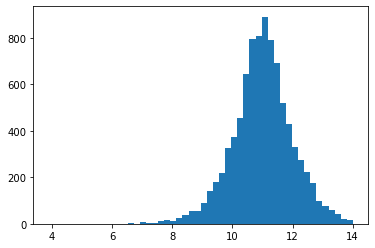

In [14]:
_ = plt.hist(y, bins=50)

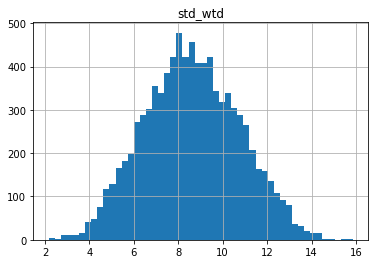

In [15]:
_ = X.hist('std_wtd', bins=50)

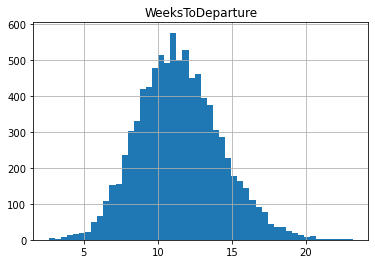

In [16]:
_ = X.hist('WeeksToDeparture', bins=50)

In [17]:
X.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [18]:
X.shape

(8902, 5)

In [19]:
print(y.mean())
print(y.std())

10.99904767212102
0.9938894125318564


## Preprocessing dates

Getting dates into numerical columns is a common operation when time series data is analyzed with non-parametric predictors. The code below makes the following transformations:

- numerical columns for year (2011-2012), month (1-12), day of the month (1-31), day of the week (0-6), and week of the year (1-52)
- number of days since 1970-01-01

In [81]:
# Make a copy of the original data to avoid writing on the original data
X_encoded = X.copy()

# following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week'] = X_encoded['DateOfDeparture'].dt.isocalendar().week
X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

In [82]:
X_encoded.tail(5)

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
8897,2011-10-02,DTW,ATL,9.263158,7.316967,2011,10,2,6,39,15249
8898,2012-09-25,DFW,ORD,12.772727,10.641034,2012,9,25,1,39,15608
8899,2012-01-19,SFO,LAS,11.047619,7.908705,2012,1,19,3,3,15358
8900,2013-02-03,ORD,PHL,6.076923,4.030334,2013,2,3,6,5,15739
8901,2011-11-26,DTW,ATL,9.526316,6.167733,2011,11,26,5,47,15304


We will perform all preprocessing steps within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) which chains together tranformation and estimator steps. This offers offers convenience and safety (help avoid leaking statistics from your test data into the trained model in cross-validation) and the whole pipeline can be evaluated with `cross_val_score`.

To perform the above encoding within a scikit-learn [pipeline](https://scikit-learn.org/stable/modules/compose.html) we will a function and using `FunctionTransformer` to make it compatible with scikit-learn API.

In [83]:
from sklearn.preprocessing import FunctionTransformer

def _encode_dates(X):
    # With pandas < 1.0, we wil get a SettingWithCopyWarning
    # In our case, we will avoid this warning by triggering a copy
    # More information can be found at:
    # https://github.com/scikit-learn/scikit-learn/issues/16191
    X_encoded = X.copy()

    # Make sure that DateOfDeparture is of datetime format
    X_encoded.loc[:, 'DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    # Encode the DateOfDeparture
    X_encoded.loc[:, 'year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded.loc[:, 'month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded.loc[:, 'day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded.loc[:, 'weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.isocalendar().week
    X_encoded.loc[:, 'n_days'] = X_encoded['DateOfDeparture'].apply(
        lambda date: (date - pd.to_datetime("1970-01-01")).days
    )
    # Once we did the encoding, we will not need DateOfDeparture
    return X_encoded.drop(columns=["DateOfDeparture"])

date_encoder = FunctionTransformer(_encode_dates)

In [84]:
date_encoder.fit_transform(X).head()

,Departure,Arrival,WeeksToDeparture,std_wtd,year,month,day,weekday,week,n_days
0,ORD,DFW,12.875000,9.812647,2012,6,19,1,25,15510
1,LAS,DEN,14.285714,9.466734,2012,9,10,0,37,15593
2,DEN,LAX,10.863636,9.035883,2012,10,5,4,40,15618
3,ATL,ORD,11.480000,7.990202,2011,10,9,6,40,15256
4,DEN,SFO,11.450000,9.517159,2012,2,21,1,8,15391


In [86]:
v=date_encoder.fit_transform(X)
v.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Departure         8902 non-null   object 
 1   Arrival           8902 non-null   object 
 2   WeeksToDeparture  8902 non-null   float64
 3   std_wtd           8902 non-null   float64
 4   year              8902 non-null   int64  
 5   month             8902 non-null   int64  
 6   day               8902 non-null   int64  
 7   weekday           8902 non-null   int64  
 8   week              8902 non-null   UInt32 
 9   n_days            8902 non-null   int64  
dtypes: UInt32(1), float64(2), int64(5), object(2)
memory usage: 669.5+ KB


## Random Forests

Tree-based algorithms requires less complex preprocessing than linear-models. We will first present a machine-learning pipeline where we will use a random forest. In this pipeline, we will need to:

- encode the date to numerical values (as presented in the section above);
- oridinal encode the other categorical values to get numerical number;
- keep numerical features as they are.

Thus, we want to perform three different processes on different columns of the original data `X`. In scikit-learn, we can use [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) to perform such processing.

In [87]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

In [90]:
v3=pd.DataFrame(preprocessor.fit_transform(v),columns = v.columns)
v3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Departure         8902 non-null   object
 1   Arrival           8902 non-null   object
 2   WeeksToDeparture  8902 non-null   object
 3   std_wtd           8902 non-null   object
 4   year              8902 non-null   object
 5   month             8902 non-null   object
 6   day               8902 non-null   object
 7   weekday           8902 non-null   object
 8   week              8902 non-null   object
 9   n_days            8902 non-null   object
dtypes: object(10)
memory usage: 695.6+ KB


We can combine our preprocessor with an estimator (`RandomForestRegressor` in this case), allowing us to make predictions.

In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
max_depth = 10
max_features = 10

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)

pipeline = make_pipeline(date_encoder, preprocessor, regressor)

We can cross-validate our `pipeline` using `cross_val_score`. Below we will have specified `cv=5` meaning KFold cross-valdiation splitting will be used, with 8 folds. The mean squared error regression loss is calculated for each split. The output `score` will be an array of 5 scores from each KFold. The score mean and standard deviation of the 5 scores is printed at the end.

In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.6297 +/- 0.0150


## Linear regressor

When dealing with a linear model, we need to one-hot encode categorical variables instead of ordinal encoding and standardize numerical variables. Thus we will:

- encode the date;
- then, one-hot encode all categorical columns, including the encoded date as well;
- standardize the numerical columns.

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = [
    "Arrival", "Departure", "year", "month", "day",
    "weekday", "week", "n_days"
]

numerical_scaler = StandardScaler()
numerical_cols = ["WeeksToDeparture", "std_wtd"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    (numerical_scaler, numerical_cols)
)

We can now combine our `preprocessor` with the `LinearRegression` estimator in a `Pipeline`:

In [28]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

pipeline = make_pipeline(date_encoder, preprocessor, regressor)

And we can evaluate our linear-model pipeline:

In [29]:
scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.6117 +/- 0.0149


# Merging external data

The objective in this RAMP data challenge is to find good data that can be correlated to flight traffic. We will use some weather data (saved in `submissions/starting_kit`) to provide an example of how to merge external data in a scikit-learn pipeline.

Your external data will need to be included in your submissions folder - see [RAMP submissions](#RAMP-submissions) for more details.

First we will define a function that merges the external data to our feature data.

In [30]:
# when submitting a kit, the `__file__` variable will corresponds to the
# path to `estimator.py`. However, this variable is not defined in the
# notebook and thus we must define the `__file__` variable to imitate
# how a submission `.py` would work.
__file__ = os.path.join('submissions', 'starting_kit', 'estimator.py')
filepath = os.path.join(os.path.dirname(__file__), 'external_data.csv')
filepath

'submissions/starting_kit/external_data.csv'

In [31]:
pd.read_csv(filepath).head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149


In [32]:
def _merge_external_data(X):
    filepath = os.path.join(
        os.path.dirname(__file__), 'external_data.csv'
    )
    
    X = X.copy()  # to avoid raising SettingOnCopyWarning
    # Make sure that DateOfDeparture is of dtype datetime
    X.loc[:, "DateOfDeparture"] = pd.to_datetime(X['DateOfDeparture'])
    # Parse date to also be of dtype datetime
    data_weather = pd.read_csv(filepath, parse_dates=["Date"])

    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
    X_merged = pd.merge(
        X, X_weather, how='left', on=['DateOfDeparture', 'Arrival'], sort=False
    )
    return X_merged

data_merger = FunctionTransformer(_merge_external_data)

Double check that our function works:

In [33]:
data_merger.fit_transform(X).head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Max TemperatureC
0,2012-06-19,ORD,DFW,12.875000,9.812647,34
1,2012-09-10,LAS,DEN,14.285714,9.466734,33
2,2012-10-05,DEN,LAX,10.863636,9.035883,22
3,2011-10-09,ATL,ORD,11.480000,7.990202,27
4,2012-02-21,DEN,SFO,11.450000,9.517159,16


Use `FunctionTransformer` to make our function compatible with scikit-learn API:

We can now assemble our pipeline using the same `data_merger` and `preprocessor` as above:

In [34]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

categorical_encoder = OrdinalEncoder()
categorical_cols = ["Arrival", "Departure"]

preprocessor = make_column_transformer(
    (categorical_encoder, categorical_cols),
    remainder='passthrough',  # passthrough numerical columns as they are
)

In [35]:
n_estimators = 10
max_depth = 10
max_features = 10

regressor = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, max_features=max_features
)

pipeline = make_pipeline(data_merger, date_encoder, preprocessor, regressor)

In [36]:
scores = cross_val_score(
    pipeline, X, y, cv=5, scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-scores)

print(
    f"RMSE: {np.mean(rmse_scores):.4f} +/- {np.std(rmse_scores):.4f}"
)

RMSE: 0.6237 +/- 0.0180


In [ ]:
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                gamma=0,                 
                learning_rate=0.07,
                max_depth=3,
                min_child_weight=1.5,
                n_estimators=10000,                                                                    
                reg_alpha=0.75,
                reg_lambda=0.45,
                subsample=0.6,
                seed=42)




## Feature importances

We can check the feature importances using the function [`sklearn.inspection.permutation_importances`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). Since the first step of our pipeline adds the new external feature `Max TemperatureC`, we want to apply this transformation after adding `Max TemperatureC`, to check the importances of all features. Indeed, we can perform `sklearn.inspection.permutation_importances` at any stage of the pipeline, as we will see later on.


The code below:

* performs `transform` on the first step of the pipeline (`pipeline[0]`) producing the transformed train (`X_train_augmented`) and test (`X_test_augmented`) data
* the transformed data is used to fit the pipeline from the second step onwards

Note that pipelines can be sliced. `pipeline[0]` obtains the first step (tuple) of the pipeline. You can further slice to obtain either the transformer/estimator (first item in each tuple) or column list (second item within each tuple) inside each tuple. For example `pipeline[0][0]` obtains the transformer of the first step of the pipeline (first item of the first tuple).

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

merger = pipeline[0]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipeline[1:]
predictor.fit(X_train_augmented, y_train).score(X_test_augmented, y_test)

0.5809192516799067

With the fitted pipeline, we can now use `permutation_importance` to calculate feature importances:

In [38]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=10
)

Here, we plot the permutation importance using the training set. The higher the value, more important the feature is.

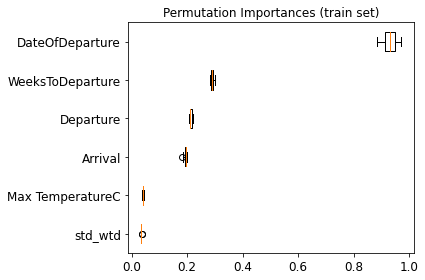

In [39]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [40]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

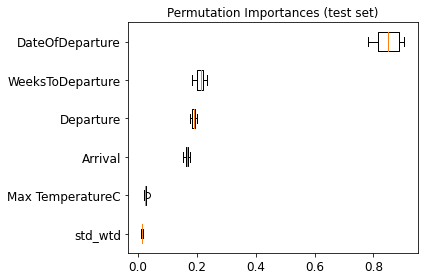

In [41]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

With the current version of scikit-learn, it is not handy but still possible to check the feature importances at the latest stage of the pipeline (once all features have been preprocessed).

The difficult part is to get the name of the features.

In [42]:
preprocessor = pipeline[:-1]
predictor = pipeline[-1]

X_train_augmented = preprocessor.transform(X_train)
X_test_augmented = preprocessor.transform(X_test)

Let's find out the feature names (in the future, scikit-learn will provide a `get_feature_names` function to handle this case).

In [43]:
categorical_cols_name = categorical_cols
passthrough_cols_name = (
    pipeline[:2].transform(X_train[:1])  # Take only one sample to go fast
    .columns[pipeline[2].transformers_[-1][-1]]
    .tolist()
)
feature_names = np.array(
    categorical_cols_name + passthrough_cols_name
)
feature_names

array(['Arrival', 'Departure', 'WeeksToDeparture', 'std_wtd',
       'Max TemperatureC', 'year', 'month', 'day', 'weekday', 'week',
       'n_days'], dtype='<U16')

We can repeat the previous processing at this finer grain, where the transformed date columns are included.

In [44]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented, y_train, n_repeats=10
)

Here, we plot the permutation importance using the training set. Basically, higher the value, more important is the feature.

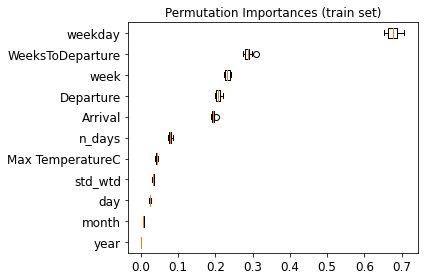

In [45]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

We can replicate the same processing on the test set and see if we can observe the same trend.

In [46]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_test_augmented, y_test, n_repeats=10
)

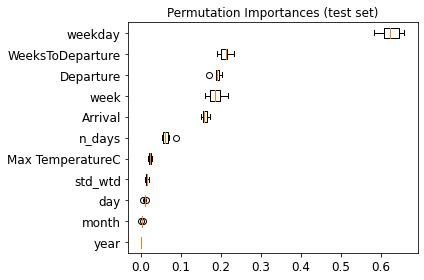

In [47]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=feature_names[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [51]:
a="blaaaaaaaaaaaaaaaaaaaablaaaaaaaaaaaaaaaaaaablaaaaaaaaaaaaaaa"
a[1:10]


'laaaaaaaa'

In [73]:
df = pd.DataFrame(np.random.randn(6, 2), columns=[" Column A ", " Column B "], index=range(6))
df[" Column A "]=df[" Column A "].astype(str)
df[" Column B "]=df[" Column B "].astype(str)
df

,Column A,Column B
0,0.6434037251108592,0.07277182699197678
1,0.8804034656620273,0.7226010466296344
2,-0.06423922674354474,0.6178891199507185
3,0.5312164132967347,-0.168300395052487
4,0.5357931525233777,-0.3169780315459642
5,-0.5680813280055383,0.28242454858456106


In [71]:
df.loc[1,' Column A '][1:10]

for i in range (len(df)):
    for j in range(0,6):
        df.loc[5+j+i*4,' Column A ']=df.loc[i,' Column A '][j+len(df.loc[i,' Column A '])/4)
        df.loc[5+j+i*4,' Column B ']=df.loc[i,' Column B ']

df

,Column A,Column B
0,0.35942496733863666,1.2225573030788055
1,-0.5949261319102663,1.2096124694774348
2,0.046941181535991056,-0.0815602027039781
6,35942496,1.2225573030788055
7,.5949261,1.2096124694774348
8,04694118,-0.0815602027039781


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).